In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 8.2MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
import torch
import torch.nn as nn   
import torch.nn.functional as F
import torchtext
from torchtext import data
import time
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
SEED = 1234
 
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
def generate_bigrams(x):
  n_grams = set(zip(*[x[i:] for i in range(2)]))
  for n_gram in n_grams:
    x.append(" ".join(n_gram))
  return x

In [5]:
TEXT = data.Field(tokenize="spacy",preprocessing=generate_bigrams,lower=True)
LABEL = data.LabelField()
fields = [(None,None),('text', TEXT),('label',LABEL), (None,None)]

In [6]:
train_data, test_data = data.TabularDataset.splits(
                                        path = '/content/drive/MyDrive/data/benchmarking_data',
                                        train = 'train.csv',
                                        test = 'valid.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [7]:
print(vars(train_data[2]))

{'text': ['play', 'a', 'sixties', 'song', 'by', 'george', 'sanger', 'a sixties', 'george sanger', 'by george', 'sixties song', 'play a', 'song by'], 'label': 'PlayMusic'}


In [8]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(test_data)}")

Number of training examples: 13784
Number of validation examples: 700


#### Create our own validation set


In [9]:
import random
train_data,valid_data = train_data.split(random_state=random.seed(SEED))

In [10]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of test examples: {len(test_data)}")

Number of training examples: 9649
Number of validation examples: 4135
Number of test examples: 700


In [11]:
MAX_VOCAB_SIZE = 25_000
 
TEXT.build_vocab(train_data,max_size=MAX_VOCAB_SIZE,
                 vectors="glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:29, 2.22MB/s]                           
100%|█████████▉| 398178/400000 [00:18<00:00, 21223.17it/s]

In [12]:
print(f"Unique tokens  in text vocab:{len(TEXT.vocab)}")
print(f"Unique tokens in label vocab:{len(LABEL.vocab)}")

Unique tokens  in text vocab:25002
Unique tokens in label vocab:7


In [13]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 5204), ('a', 3108), ('to', 2418), ('in', 2412), ('for', 2131), ('of', 1787), ('.', 1681), ('i', 1580), ('at', 1469), ('play', 1340), ('is', 1141), ('add', 1139), ('book', 1125), ('what', 1061), ('my', 1007), ('find', 964), ('playlist', 949), ('me', 855), ('?', 852), ('on', 844)]


In [14]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', 'a', 'to', 'in', 'for', 'of', '.', 'i']


In [15]:
print(LABEL.vocab.stoi)

defaultdict(None, {'PlayMusic': 0, 'BookRestaurant': 1, 'AddToPlaylist': 2, 'GetWeather': 3, 'SearchScreeningEvent': 4, 'RateBook': 5, 'SearchCreativeWork': 6})


In [16]:
BATCH_SIZE = 64
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
train_iterator,valid_iterator,test_iterator = data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True,
    sort_key=lambda x:len(x.text))

In [17]:
class FastText(nn.Module):
  def __init__(self,vocab_size,embedding_dim,output_dim,pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,embedding_dim)
    self.fc = nn.Linear(embedding_dim,output_dim)
  
  def forward(self,text):
    #text = [sent_len,batch_size]
    embedded = self.embedding(text)
    #embedded = [sent_len,batch_size,emb_dim]
    embedded = embedded.permute(1,0,2)
    #embedded =  [batch_size,sent_len,emb_dim]
    pooled = F.avg_pool2d(embedded,(embedded.shape[1],1)).squeeze(1)
    #pooled = [batch_size,sent_len]
    return self.fc(pooled)

In [18]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
 
model = FastText(INPUT_DIM,EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
 
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,526,056 trainable parameters


In [ ]:
import torch.optim as optim
 
lr=1e-3
optimizer = optim.Adam(model.parameters(),lr=lr)
#sched = optim.lr_scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text)
        
        loss = criterion(predictions,batch.label)
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
 
            predictions = model(batch.text)
            
            loss = criterion(predictions,batch.label)
            
            acc = categorical_accuracy(predictions,batch.label)
 
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5
 
best_valid_loss = float('inf')
 
for epoch in range(N_EPOCHS):
 
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
 
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Models/INTENT/rnn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.997 | Train Acc: 89.60%
	 Val. Loss: 0.680 |  Val. Acc: 88.52%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.524 | Train Acc: 93.98%
	 Val. Loss: 0.432 |  Val. Acc: 91.79%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.318 | Train Acc: 95.83%
	 Val. Loss: 0.306 |  Val. Acc: 94.13%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.217 | Train Acc: 96.90%
	 Val. Loss: 0.236 |  Val. Acc: 95.23%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.159 | Train Acc: 97.72%
	 Val. Loss: 0.196 |  Val. Acc: 95.72%


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Models/INTENT/bag-of-tricks-model.pt"))

test_loss, test_acc = evaluate(model,test_iterator,criterion)
print(f"Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f}")

Test Loss: 0.133 | Test Accuracy: 0.96


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
 
    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
 
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    B = (C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]

In [ ]:
def get_predictions(model,iterator):
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for batch in iterator:

      text = batch.text

      predictions = model(text)

      y_pred.extend(torch.argmax(predictions,axis=-1).tolist())
      y_true.extend(batch.label.tolist())

  return y_pred,y_true

-------------------- Confusion matrix --------------------


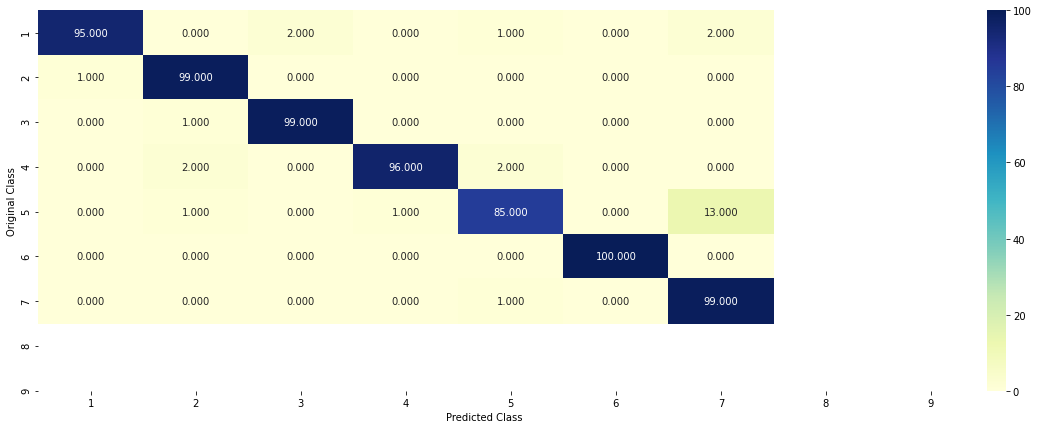

-------------------- Precision matrix (Columm Sum=1) --------------------


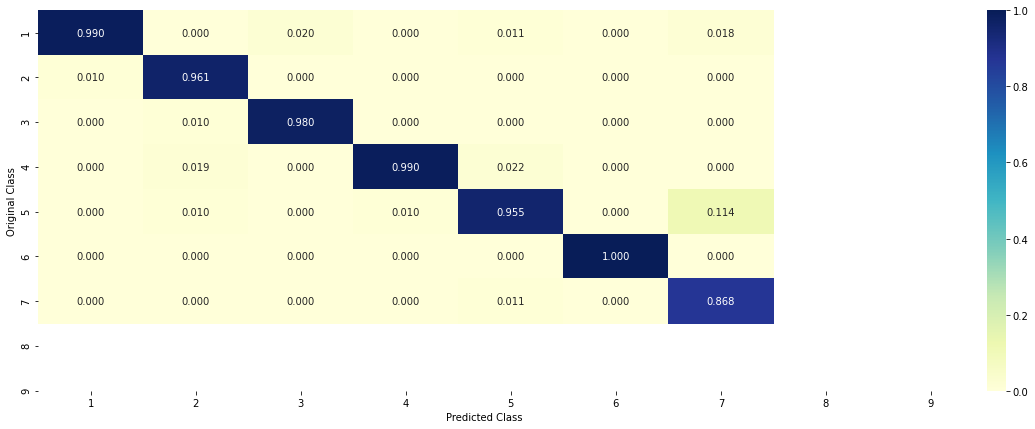

-------------------- Recall matrix (Row sum=1) --------------------


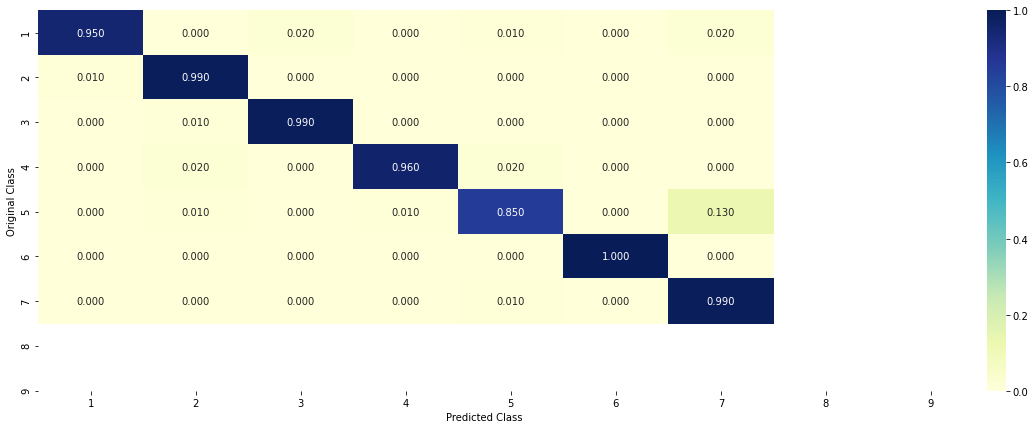

In [ ]:
y_pred,y_true = get_predictions(model,test_iterator)
plot_confusion_matrix(y_true,y_pred)

In [ ]:
print('Classification Report:')
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       100
           1       0.96      0.99      0.98       100
           2       0.98      0.99      0.99       100
           3       0.99      0.96      0.97       100
           4       0.96      0.85      0.90       100
           5       1.00      1.00      1.00       100
           6       0.87      0.99      0.93       100

    accuracy                           0.96       700
   macro avg       0.96      0.96      0.96       700
weighted avg       0.96      0.96      0.96       700

